In [1537]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys

import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision.transforms import v2

sys.path.append(r'C:\vscodeProjects\WikiArt_Inpainting\model\inpainting\FeatureExtractor')
sys.path.append(r'C:\vscodeProjects\WikiArt_Inpainting\model\inpainting\Clustering')

from FeatureExtractor import FeatureExtractor
from UNetLightning import UNetLightning
from Clusterizer import Clusterizer

CURRENT_DIR = os.getcwd()

In [1538]:
class WikiArtDatasetCluster(Dataset):
    def __init__(self, h5_path: str, mask_h5_path: str, csv_path: str, set_type: str, group_id=None, label_col='style', transform=None):
        self.h5_path = h5_path
        self.mask_h5_path = mask_h5_path
        
        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df['set_type'] == set_type]

        if group_id is not None:
            self.df = self.df[self.df['cluster_label'] == group_id]
        
        self.label_col = label_col
        self.transform = transform
        
        self.length = len(self.df)
  
        with h5py.File(self.mask_h5_path, 'r') as mask_h5f:
            self.num_masks = mask_h5f['mask'].shape[0]

    def __len__(self):
        return self.length

    def _open_hdf5(self):
        if not hasattr(self, '_hf') or self._hf is None:
            self._hf = h5py.File(self.h5_path, 'r')

        if not hasattr(self, '_mask_hf') or self._mask_hf is None:
            self._mask_hf = h5py.File(self.mask_h5_path, 'r')

    def _get_random_mask(self):
        mask_idx = np.random.randint(0, self.num_masks)
        mask = self._mask_hf['mask'][mask_idx]
        return mask
    
    def __getitem__(self, idx):
        self._open_hdf5()

        row = self.df.iloc[idx]
        image_idx = row['h5_index']

        label = row[self.label_col]

        image = self._hf['image'][image_idx]
        image = torch.from_numpy(image)

        mask = self._get_random_mask()
        mask = torch.from_numpy(mask).float()
        
        if self.transform:
            image = self.transform(image)

        return image, mask, label

In [1539]:
class WikiArtDatasetInpainting(Dataset):
    def __init__(self, h5_path: str, mask_h5_path: str, csv_path: str, set_type: str, group_id=None, label_col='style', transform=None):
        self.h5_path = h5_path
        self.mask_h5_path = mask_h5_path
        
        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df['set_type'] == set_type]

        if group_id is not None:
            self.df = self.df[self.df['cluster_label'] == group_id]
        
        self.label_col = label_col
        self.transform = transform
        
        self.length = len(self.df)
  
        with h5py.File(self.mask_h5_path, 'r') as mask_h5f:
            self.num_masks = mask_h5f['mask'].shape[0]

    def __len__(self):
        return self.length

    def _open_hdf5(self):
        if not hasattr(self, '_hf') or self._hf is None:
            self._hf = h5py.File(self.h5_path, 'r')

        if not hasattr(self, '_mask_hf') or self._mask_hf is None:
            self._mask_hf = h5py.File(self.mask_h5_path, 'r')

    def _get_random_mask(self):
        mask_idx = np.random.randint(0, self.num_masks)
        mask = self._mask_hf['mask'][mask_idx]
        return mask
    
    def __getitem__(self, idx):
        self._open_hdf5()

        row = self.df.iloc[idx]
        image_idx = row['h5_index']

        label = row[self.label_col]

        image = self._hf['image'][image_idx]
        image = torch.from_numpy(image).float()

        mask = self._get_random_mask()
        mask = torch.from_numpy(mask).float()
        
        if self.transform:
            image = self.transform(image)

        return image, mask, label

In [1540]:
class UNetInpainting(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, use_dropout=False):
        super().__init__()
        self.use_dropout = use_dropout

        self.encoder1 = self.conv_block(in_channels, 16)
        self.encoder2 = self.conv_block(16, 32, pool=True)
        self.encoder3 = self.conv_block(32, 64, pool=True)
        self.encoder4 = self.conv_block(64, 128, pool=True)

        self.bottleneck = self.conv_block(128, 256, pool=True)

        self.decoder4 = self.upconv_block(256, 128)
        self.decoder3 = self.upconv_block(128, 64)
        self.decoder2 = self.upconv_block(64, 32)
        self.decoder1 = self.upconv_block(32, 16)

        self.final_conv = nn.Conv2d(16, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels, pool=False):
        layers = []
        if pool:
            layers.append(nn.MaxPool2d(kernel_size=2))
        layers.extend([
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        ])
        if self.use_dropout:
            layers.append(nn.Dropout(0.5))
        return nn.Sequential(*layers)

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x, mask):
        x_with_mask = x * (1 - mask)

        x_with_mask_and_mask = torch.cat([x_with_mask, mask], dim=1)

        e1 = self.encoder1(x_with_mask_and_mask)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        b = self.bottleneck(e4)

        d4 = self.decoder4(b) + e4
        d3 = self.decoder3(d4) + e3
        d2 = self.decoder2(d3) + e2
        d1 = self.decoder1(d2) + e1

        output = self.final_conv(d1)

        output = output * mask + x * (1 - mask)
    
        return output

In [1541]:
def load_model(weights_path, model_class, device='cpu'):
    model = model_class()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()
    return model

In [1542]:
def visualize_results(original, masked, mask, output):
    original = original.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    masked = masked.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    mask = mask.squeeze(0).cpu().numpy().astype(np.uint8)
    output = output.permute(1, 2, 0).detach().cpu().numpy().clip(0, 255).astype(np.uint8)

    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].imshow(original)
    ax[0].set_title('Original')
    ax[1].imshow(masked)
    ax[1].set_title('Masked')
    ax[2].imshow(mask, cmap='gray')
    ax[2].set_title('Mask')
    ax[3].imshow(output)
    ax[3].set_title('Output')
    for a in ax:
        a.axis('off')
    plt.show()

In [1543]:
def evaluate_sample(image, mask, label, model, device='cuda'):
    model.to(device)

    image = image.to(device).unsqueeze(0)
    mask = torch.from_numpy(mask).float().to(device).unsqueeze(0).unsqueeze(0)

    masked_image = image * (1 - mask)

    with torch.no_grad():
        output = model(image, mask)

    visualize_results(
        original=image.squeeze(0),
        masked=masked_image.squeeze(0),
        mask=mask.squeeze(0),
        output=output.squeeze(0)
    )

    print('Cluster label:', label.item())

In [1544]:
model_paths = {
    0 : f'{CURRENT_DIR}\\weights\\0\\best_weights_epoch_13_val_loss_1.9445-195.pth',
    1 : f'{CURRENT_DIR}\\weights\\1\\best_weights_epoch_0_val_loss_3.9911.pth',
    2 : f'{CURRENT_DIR}\\weights\\2\\best_weights_epoch_7_val_loss_5.2359-79.pth',
    3 : f'{CURRENT_DIR}\\weights\\3\\best_weights_epoch_0_val_loss_4.9286.pth',
    4 : f'{CURRENT_DIR}\\weights\\4\\best_weights_epoch_0_val_loss_2.7693-13.pth',
    5 : f'{CURRENT_DIR}\\weights\\5\\best_weights_epoch_15_val_loss_2.8780-239.pth'
}

In [1545]:
transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [1546]:
h5_path = f'{CURRENT_DIR}\\dataset\\dataset.h5'
annotations_path = f'{CURRENT_DIR}\\dataset\\annotations.csv'
mask_h5_path = f'{CURRENT_DIR}\\masks\\square.h5'

test_dataset_inpainting = WikiArtDatasetInpainting(h5_path, mask_h5_path, annotations_path, 'test')
test_dataset = WikiArtDatasetCluster(h5_path, mask_h5_path, annotations_path, 'test', transform=transforms)

In [1547]:
model = UNetLightning()

In [1548]:
feature_extractor = FeatureExtractor(model, 'cpu', None, '')

print(feature_extractor.summary()) 

GPU available: False, used: False


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
UNet                                     [1, 3, 224, 224]          [1, 3, 224, 224]          --                        --
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 16, 224, 224]         --                        --
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 16, 224, 224]         448                       [3, 3]
│    └─ReLU: 2-2                         [1, 16, 224, 224]         [1, 16, 224, 224]         --                        --
│    └─BatchNorm2d: 2-3                  [1, 16, 224, 224]         [1, 16, 224, 224]         32                        --
│    └─Conv2d: 2-4                       [1, 16, 224, 224]         [1, 16, 224, 224]         2,320                     [3, 3]
│    └─ReLU: 2-5                         [1, 16, 224, 224]         [1, 16, 224, 224]         --                        --
│    └

In [1549]:
best_model_path = f'{CURRENT_DIR}\\Models\\best_model.pth'
feature_extractor.load_from_checkpoint(best_model_path)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model załadowany z pliku .pth: c:\vscodeProjects\WikiArt_Inpainting\model\inpainting\Models\best_model.pth
Pomyślnie załadowano model. Trainer ustawiony na 1 epok.


In [1550]:
feature_extractor.evaluate()

UNetLightning(
  (model): UNet(
    (encoder1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (encoder2): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (encoder3): Sequent

In [1551]:
current_image_idx = np.random.randint(0, len(test_dataset))

image, _, _ = test_dataset[current_image_idx]
print(np.shape(image))

features = feature_extractor.single_features_extract(image)
print(np.shape(features))

torch.Size([3, 224, 224])
(1, 28)


c:\.conda\envs\unn\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\.conda\envs\unn\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [1552]:
clusterizer = Clusterizer(None)

In [1553]:
n_clusters = 6

In [1554]:
cluster_label = clusterizer.clusterize('test', n_clusters, features)
print(cluster_label)

Załadowano model KMeans z: C:scodeProjects\WikiArt_Inpainting\model\inpainting\Models\kmeans_model.pkl
[1]


c:\.conda\envs\unn\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.6.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [1555]:
image, _, _ = test_dataset_inpainting[current_image_idx]

model = load_model(model_paths[cluster_label[0]], UNetInpainting)

mask = test_dataset._get_random_mask()

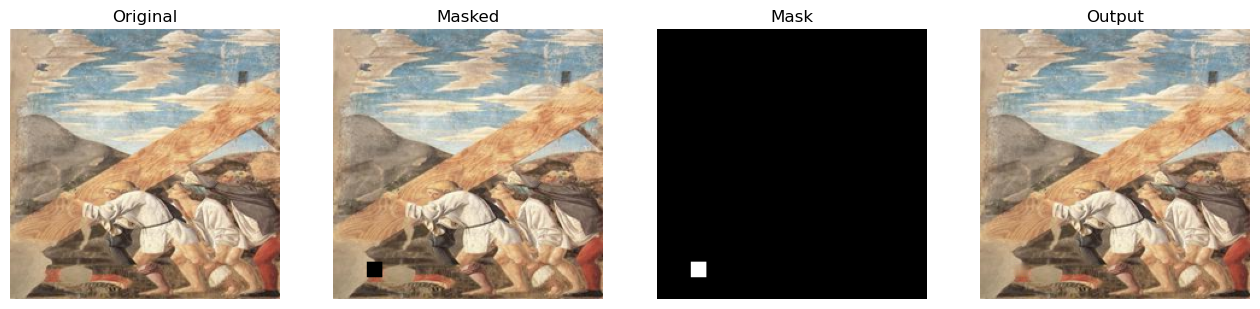

Cluster label: 1


In [1556]:
evaluate_sample(image, mask, cluster_label, model, device='cpu')